<a href="https://colab.research.google.com/github/ashesh-0/PdfFromImages/blob/master/PageMidBoundaryPixelSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Code inspiration taken from https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

*   Data created using https://labelbox.com



# Fetching Images and their masks

In [0]:
!pip install -q albumentations==0.3.0
!pip install -q segmentation-models

In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

In [140]:
from google.colab import drive    
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
BATCH_SIZE = 8

In [0]:
import json
import numpy
from PIL import Image, ImageDraw
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np

ORIG_SIZE = (1536, 2048)
TRAIN_JSON_FPATH = 'train.json'
VAL_JSON_FPATH = 'val.json'


def plot_midline(img, mask):
    _, ax = plt.subplots(figsize=(5, 5))
    img = img.copy()
    img[mask > 0, 0] = np.max(img)
    img[mask > 0, 1] = 0
    img[mask > 0, 2] = 0
    imshow(img, ax=ax)


def plot(img, mask):
    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    imshow(img, ax=ax[0])
    imshow(img * (mask.reshape(mask.shape[0], mask.shape[1], 1)), ax=ax[1])


def load_json(fpath):
    with open(fpath, 'r') as f:
        lines = f.read().strip().splitlines()
    assert len(lines) == 1
    output = json.loads(lines[0])
    return [p for p in output if p['External ID'] != 'title.jpg']


def get_midline_mask(row):
    """
    Returns the mask {0,1} array for the image represented by row.
    """
    line = row['Label']['midline'][0]['geometry']
    line = [(r['x'], r['y']) for r in line]
    mask = Image.new('L', (ORIG_SIZE[1], ORIG_SIZE[0]), 0)
    ImageDraw.Draw(mask).line(line, width=30, fill='white')
    return numpy.array(mask) // 255


def get_mask(row):
    """
    Returns the mask {0,1} array for the image represented by row.
    """
    polygon = row['Label']['page'][0]['geometry']
    polygon = [(r['x'], r['y']) for r in polygon]
    mask = Image.new('L', (ORIG_SIZE[1], ORIG_SIZE[0]), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return numpy.array(mask)


def get_img(row, directory):
    """
    Args:
        row: one row of LabelMe generated json
        directory: directory where all images are stored

    It returns the image array
    """
    return imread(os.path.join(directory, row['External ID']))


def train_validation_separation(json_fpath, val_fraction=0.2):
    json_data = load_json(json_fpath)
    train_data, validation_data = train_test_split(json_data, test_size=val_fraction)
    with open(TRAIN_JSON_FPATH, 'w') as f:
        f.write(json.dumps(train_data))
    with open(VAL_JSON_FPATH, 'w') as f:
        f.write(json.dumps(validation_data))


In [0]:
DATA_DIR = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/'
raw_data = load_json(os.path.join(DATA_DIR,'export-2019-12-20T02_15_02.061Z.json'))


In [144]:
raw_data[0]

{'Agreement': None,
 'Benchmark Agreement': None,
 'Benchmark ID': None,
 'Benchmark Reference ID': None,
 'Created At': '2019-12-04T10:52:10.000Z',
 'Created By': 'ashesh276@gmail.com',
 'DataRow ID': 'ck3r5lj37aw7x0gmvaafkfkcf',
 'Dataset Name': 'BookPages',
 'External ID': '20180503_075259.jpg',
 'ID': 'ck3r69crrxggd0872f5imo76r',
 'Label': {'midline': [{'geometry': [{'x': 975, 'y': 118},
     {'x': 1066, 'y': 1525}]}],
  'page': [{'geometry': [{'x': 119, 'y': 96},
     {'x': 198, 'y': 51},
     {'x': 382, 'y': 3},
     {'x': 851, 'y': 6},
     {'x': 942, 'y': 48},
     {'x': 962, 'y': 99},
     {'x': 993, 'y': 113},
     {'x': 1069, 'y': 93},
     {'x': 1211, 'y': 76},
     {'x': 1479, 'y': 59},
     {'x': 1782, 'y': 45},
     {'x': 2036, 'y': 1140},
     {'x': 2048, 'y': 1177},
     {'x': 2045, 'y': 1519},
     {'x': 1813, 'y': 1533},
     {'x': 74, 'y': 1536}]}]},
 'Labeled Data': 'https://storage.labelbox.com/ck3r4j2vkgfwg0800h4deut1a%2F9e54dc63-bf8e-0042-f993-bd39a39d4aa7-20180

In [0]:
train_validation_separation(os.path.join(DATA_DIR,'export-2019-12-20T02_15_02.061Z.json'))

### Looking at the input image and the target image.
We want to remove the background and just want the book.

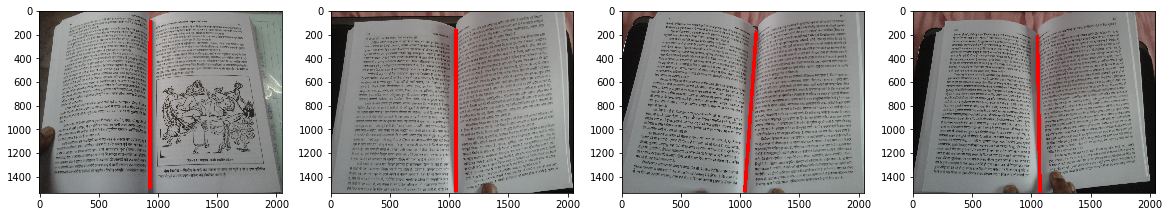

In [146]:
_,ax=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
for idx, i in enumerate(np.random.choice(len(raw_data),size=4,replace=False)):
  img = get_img(raw_data[i],os.path.join(DATA_DIR,'data'))
  mask =get_midline_mask(raw_data[i])
  img[mask>0,0] = 254
  img[mask>0,1] = 0
  img[mask>0,2] = 0
  ax[idx].imshow(img)
  

## Data Preparation for model training

In [0]:
import keras
# from data_utils import get_img, get_mask, load_json
import numpy as np
import albumentations as A

IMG_SIZE = (320, 320)
MIN_SCALE = 0.5


def get_training_augmentation():
    # Taken and modified from
    #  https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=90, shift_limit=0.1, p=1, border_mode=0),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    return A.Compose([A.Resize(IMG_SIZE[0], IMG_SIZE[1])], p=1)


class DataLoader:
    def __init__(
            self,
            json_path: str,
            img_directory: str,
            augmentation=None,
            batch_size: int = 8,
            load_midline_data=False,
    ):
        """
        Args:
            json_path: path of the json file generated by Labelbox website.
            img_directory: directory where images are present
        """
        self.load_midline_data = load_midline_data
        self.json = load_json(json_path)
        self.imgs = np.stack([get_img(row, img_directory) for row in self.json], axis=0)
        if self.load_midline_data:
            self.masks = np.stack([get_midline_mask(row) for row in self.json], axis=0)
        else:
            self.masks = np.stack([get_mask(row) for row in self.json], axis=0)
        self.masks = self.masks.reshape((self.masks.shape[0], self.masks.shape[1], self.masks.shape[2], 1))
        self.aug = augmentation

    def __getitem__(self, i):
        if self.aug is not None:
            sample = self.aug(image=self.imgs[i], mask=self.masks[i])
            return (sample['image'], sample['mask'])

        return (self.imgs[i].copy(), self.masks[i].copy())

    def __len__(self):
        return len(self.imgs)


class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 json_path: str,
                 img_directory: str,
                 augmentation=None,
                 batch_size: int = 8,
                 load_midline_data=False):
        """
        Args:
            json_path: path of the json file generated by Labelbox website.
            img_directory: directory where images are present
        """
        self.batch_size = batch_size
        self.dataset = DataLoader(
            json_path,
            img_directory,
            augmentation=augmentation,
            batch_size=batch_size,
            load_midline_data=load_midline_data,
        )

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.dataset) // self.batch_size


In [0]:
# JSON_PATH = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/book_segmentation.json'
IMG_DIR = '/content/gdrive/My Drive/Colab_data/PagePixelSegmentation/data'

aug = get_training_augmentation()
datagen = DataGenerator(TRAIN_JSON_FPATH,IMG_DIR,augmentation=aug,batch_size=BATCH_SIZE,load_midline_data=True)

In [0]:
val_datagen = DataGenerator(VAL_JSON_FPATH,IMG_DIR,augmentation=get_validation_augmentation(),batch_size=BATCH_SIZE,load_midline_data=True)

In [150]:
len(val_datagen)/len(datagen)

0.25

In [151]:
img.shape

(1536, 2048, 3)

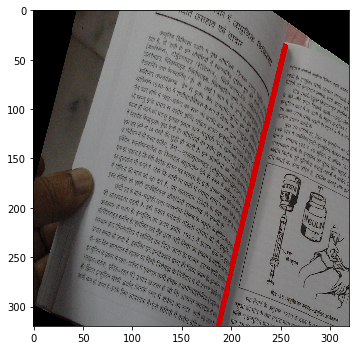

In [152]:
sample = datagen[10]
img,msk = sample[0][0],sample[1][0]
plot_midline(img,msk[:,:,0])

## Model training

In [0]:
import segmentation_models as sm


In [0]:
BACKBONE = 'efficientnetb3'
LR = 0.0001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=1, activation=activation)

In [0]:
optim = keras.optimizers.Adam(LR)
total_loss = sm.losses.binary_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
model_path = os.path.join(DATA_DIR,'mid_boundary_pixel.h5')
if os.path.exists(model_path):
  model.load_weights(model_path)

In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [159]:
history = model.fit_generator(
    datagen, 
    steps_per_epoch=len(datagen), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_datagen, 
    validation_steps=len(val_datagen),
)

Epoch 1/30
12/12 [==============================] - 67s 6s/step - loss: 0.2606 - iou_score: 0.7227 - f1-score: 0.8378 - val_loss: 0.2331 - val_iou_score: 0.7579 - val_f1-score: 0.8619
Epoch 2/30
12/12 [==============================] - 5s 421ms/step - loss: 0.2552 - iou_score: 0.7272 - f1-score: 0.8414 - val_loss: 0.2313 - val_iou_score: 0.7610 - val_f1-score: 0.8640
Epoch 3/30
12/12 [==============================] - 24s 2s/step - loss: 0.2361 - iou_score: 0.7418 - f1-score: 0.8512 - val_loss: 0.2291 - val_iou_score: 0.7557 - val_f1-score: 0.8608
Epoch 4/30
12/12 [==============================] - 23s 2s/step - loss: 0.2506 - iou_score: 0.7243 - f1-score: 0.8394 - val_loss: 0.2246 - val_iou_score: 0.7608 - val_f1-score: 0.8639
Epoch 5/30
12/12 [==============================] - 22s 2s/step - loss: 0.2443 - iou_score: 0.7291 - f1-score: 0.8419 - val_loss: 0.2182 - val_iou_score: 0.7684 - val_f1-score: 0.8687
Epoch 6/30
12/12 [==============================] - 24s 2s/step - loss: 0.2371

In [0]:
val_X = []
for elem in val_datagen:
  val_X.append(elem[0])
val_X = np.concatenate(val_X,axis=0)

## Visual evaluation on validation set.
We can see from results that they are pretty good. However, when we will want to get the mask on original dimension image, there will be blur at the boundary due to upsampling.  For fixing it, I'll need to do something on top of this. One option is to fit a CRF to sharpen the edges should be doable.

In [0]:
val_pred = model.predict(val_X)

In [167]:
np.max(val_pred)

0.99998915

**Plot showing original image, learned filter and the image after filter application**

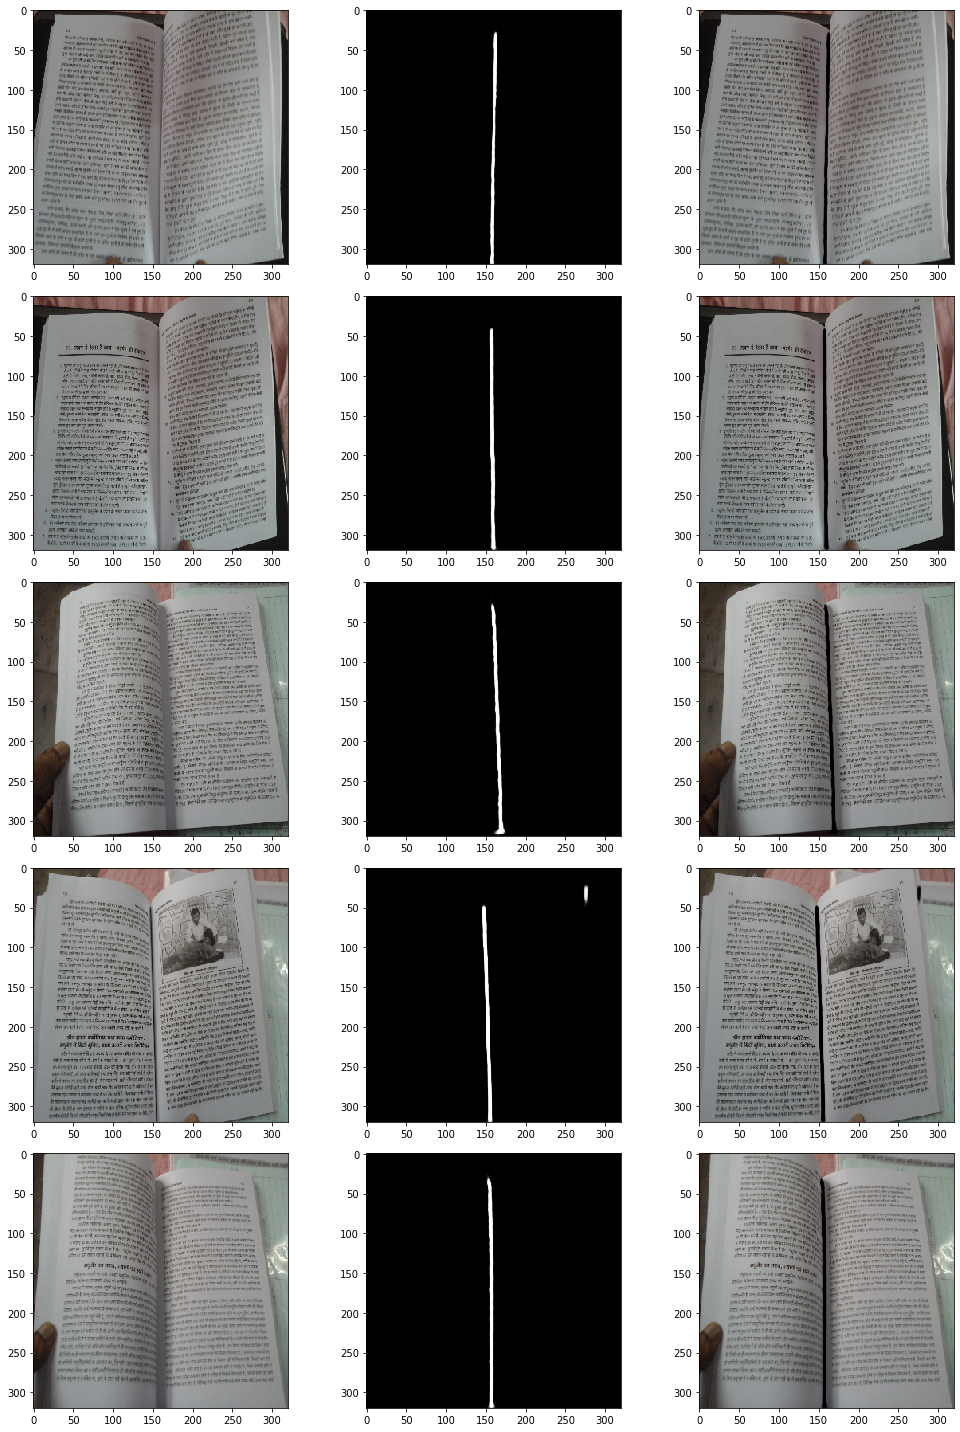

In [168]:
fig,ax = plt.subplots(nrows = 5,ncols = 3, figsize=(15,20))

for idx, i in enumerate(np.random.choice(len(val_pred)-1,size=5,replace=False)):
  imshow(val_X[i],ax=ax[idx,0])
  imshow(val_pred[i,:,:,0],ax=ax[idx,1])
  imshow(val_X[i]*(1 - val_pred[i,:,:])/255,ax=ax[idx,2])

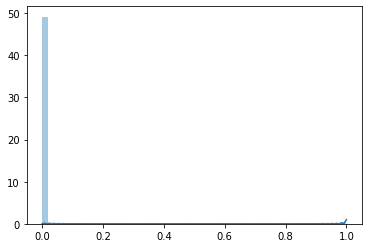

In [164]:
import seaborn as sns
sns.distplot(val_pred.reshape((-1,)))